# Aim

To predict how likely a customer would respond to the insurance offer.

In [1]:
'''Definning path of the project'''
path = "D:/customer_quality_prediction/"

# Import Libraries

In [72]:
#importing standard packages
import os
import pandas as pd
import pickle
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn import metrics

os.chdir(path)

#importing Functions created for Modeling purpose
exec(open("modeling_functions.py").read())

import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [3]:
data = pd.read_csv(path + 'data/training_csv.csv')

#dropping column 'profit', as it a target variable for a different problem
data.drop(columns = ['profit'], inplace = True)


#converting 'responded' variable from ('yes', 'no') to (1,0)
data['responded'] = np.where(data['responded'] == 'yes', 1, 0)


#id is unique_identifier and responded is our target variable, so dropping them from features dataframe
features_data = data.drop(columns = ['id', 'responded'])

print('This dataset contains {} features for {} customers.'.format(features_data.shape[1], features_data.shape[0]))

#Glimpse of the data
data.head()

This dataset contains 21 features for 8238 customers.


,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,...,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,responded,id
0,34.0,admin.,single,university.degree,no,no,yes,cellular,apr,wed,...,nonexistent,-1.8,93.075,-47.1,1.498,5099.1,999.0,0,0,1
1,31.0,services,single,high.school,no,no,no,cellular,jul,thu,...,nonexistent,1.4,93.918,-42.7,4.968,5228.1,999.0,0,0,2
2,NaN,admin.,single,high.school,no,no,no,telephone,jun,NaN,...,nonexistent,1.4,94.465,-41.8,4.961,5228.1,999.0,0,0,3
3,52.0,admin.,divorced,university.degree,unknown,yes,no,cellular,jul,tue,...,nonexistent,1.4,93.918,-42.7,4.962,5228.1,999.0,0,0,4
4,39.0,blue-collar,single,NaN,unknown,yes,no,cellular,jul,tue,...,nonexistent,1.4,93.918,-42.7,4.961,5228.1,999.0,0,0,5


## Features

In [4]:
#Columns in the dataframe
print("Features: \n" + str(list(features_data.columns)))

Features: 
['custAge', 'profession', 'marital', 'schooling', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'pmonths', 'pastEmail']


### Numeric Variables 

In [5]:
numeric_var = list(features_data._get_numeric_data().columns)
print("Numeric Features: \n" + str(numeric_var))

Numeric Features: 
['custAge', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'pmonths', 'pastEmail']


### Nominal variables

In [6]:
nominal_var = list(set(features_data.columns) - set(numeric_var))
print("Nominal Features: \n" + str(nominal_var))

Nominal Features: 
['loan', 'marital', 'poutcome', 'housing', 'schooling', 'contact', 'profession', 'day_of_week', 'default', 'month']


# Response Rate 

analysing the target variable: Customer response data 

Response Rate (percentage):
0    88.73513
1    11.26487
Name: responded, dtype: float64

This means, 11.26% customers responded to the campaign.


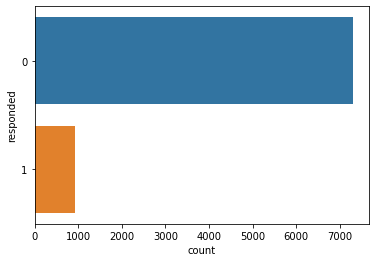

In [7]:
sns.countplot(y='responded', data = data)
response_rate = data['responded'].value_counts() * 100 / len(data)
print("Response Rate (percentage):")
print(response_rate)
print("\nThis means, {0:.2f}% customers responded to the campaign.".format(response_rate[1]))

# Split Dataset

Splitting dataset at the begining to avoid bias of test set in the model, caused at pre-processing or feature selection step.

In [8]:
target_var = 'responded'
X = data.drop(columns = [target_var])
y = data[target_var]
X_col_names = list(X.columns)

#splitting data, using stratified technique, setting test size as 15% (To have atleast 100 response cases in test set)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.15,
                                                    stratify = data[target_var],
                                                    random_state  = 1000)

X_train = pd.DataFrame(X_train)
X_train.columns = X_col_names
y_train = pd.DataFrame(y_train)
y_train.columns = [target_var]

X_test = pd.DataFrame(X_test)
X_test.columns = X_col_names
y_test = pd.DataFrame(y_test)
y_test.columns = [target_var]

#Train and Test dataframe:
data_train = pd.concat([X_train, y_train], axis = 1)
data_test = pd.concat([X_test, y_test], axis = 1)

#reseting index
data_train.reset_index(drop = True, inplace = True)
data_test.reset_index(drop = True, inplace = True)

#saving train and test dataframe as pickle
data_train.to_pickle(path + "pickle_response_model/data_train.p")
data_test.to_pickle(path + "pickle_response_model/data_test.p")

### Train Data Response Rate

In [9]:
response_dist = data_train['responded'].value_counts() 
print("Train set has {} customers, in which {} customers responded and {} customers didn't respond.\n".format(len(data_train), response_dist[1], response_dist[0]))
print("Response Rate (percentage):")
response_rate = response_dist * 100 / len(data_train)
print(response_rate)
print("\nThis means, {0:.2f}% customers in train data responded to the campaign.".format(response_rate[1]))

Train set has 7002 customers, in which 789 customers responded and 6213 customers didn't respond.

Response Rate (percentage):
0    88.731791
1    11.268209
Name: responded, dtype: float64

This means, 11.27% customers in train data responded to the campaign.


### Test Data Response Rate

In [10]:
response_dist = data_test['responded'].value_counts() 
print("Test set has {} customers, in which {} customers responded and {} customers didn't respond.\n".format(len(data_test), response_dist[1], response_dist[0]))
print("Response Rate (percentage):")
response_rate = response_dist * 100 / len(data_test)
print(response_rate)
print("\nThis means, {0:.2f}% customers in test data responded to the campaign.".format(response_rate[1]))

Test set has 1236 customers, in which 139 customers responded and 1097 customers didn't respond.

Response Rate (percentage):
0    88.754045
1    11.245955
Name: responded, dtype: float64

This means, 11.25% customers in test data responded to the campaign.


#### --------------------------------  From this point, only taking training datset into account as Model population --------------------------------

In [11]:
#loading train data
data_train = pd.read_pickle(path + "pickle_response_model/data_train.p")

# Data Pre-processing

## 1. Null Imputation

identifying variables having null and imputing them with certain value.

In [12]:
#getting the count of null for each variable
null_count = data_train.isna().sum()

#getting only the variables with nulls
print("variables having null and count of nulls:")
null_count[null_count > 0]

variables having null and count of nulls:


custAge        1708
schooling      2038
day_of_week     659
dtype: int64

Above 3 variables have null values, let's handle them

#### Handling custAge

To impute using mean or median value and keep the distribution unaffected, let's first check whether the given sample is drawn from Normal Distribution or not. Checking Normality can help us understand that this feature follows the property of Normal distribution

To check Normality, Shapiro-Wilk test is used. The null hypothesis is: sample drawn from Normal Distribution. If pval > 0.05, then we can't reject the null hypothesis. i.e. Sample is drawn from Normal Distribution.

If it is from Normal distribution then let's check it's skewness.

In [13]:
data_train_custAge = data_train[['id','custAge']]

#shapiro-wilk's test: to check normality
shapiro_test = stats.shapiro(data_train_custAge['custAge'])
print("custAge: \nShapiro-Wilk pval:" + str(shapiro_test.pvalue))
print('Skewness is',data_train_custAge['custAge'].skew())


custAge: 
Shapiro-Wilk pval:1.0
Skewness is 0.8502240012995324


As pval is 1, it shows we can't reject the null hypothesis, i.e. sample is drawn from Normal Distribution.

Skewness is 0.85 indicating right skew. Hence Median < Mean.

As sample is taken from Normal Distribution, it would be a better guess to take Mean as a value for imputation.

In [14]:
mean = data_train['custAge'].mean()
data_train['custAge_meanImputed'] = np.where(data_train['custAge'].isna(), mean, data_train['custAge'])

#Also creating a new 'custAge' variable with imputation as -999, to analyse missing value trend with target variable
data_train['custAge_constImputation'] = np.where(data_train['custAge'].isna(), -999, data_train['custAge'])

data_train[['custAge', 'custAge_meanImputed', 'custAge_constImputation']].describe()

#dropping 'custAge' as we have two columns for the same.
data_train.drop(columns = ['custAge'], inplace = True)

#### handling schooling

In [15]:
#unique catgories in schooling
data_train['schooling'].unique()

array([nan, 'university.degree', 'high.school', 'basic.9y',
       'professional.course', 'basic.4y', 'basic.6y', 'unknown'],
      dtype=object)

In [16]:
#Imputing null with 'unkown' as already there is a bucket called 'unkown'
data_train['schooling'] = np.where(data_train['schooling'].isna(), 'unknown', data_train['schooling'])

#### Handling day_of_week

In [17]:
#taking 'never' as a category for null imputation of day_of_Week 
#because this variable means last day of contact, and taking 'never' will represent customer is never contacted before*.
# *assuming there is no mistake in collecting 'day_of_week'
data_train['day_of_week'] = np.where(data_train['day_of_week'].isna(), 'Never', data_train['day_of_week'])

## 2. Feature engineering

In [18]:
#creating a new featue: 'fl_first_time_contact' from 'previous'
data_train['fl_first_time_contact'] = np.where(data_train['previous'] > 0, 0, 1)

## 3. Binning

Binning numeric features to reduce the noise (to avoid overfitting) and treat outlier in an appropriate way.

In [19]:
#understanding Numeric Data by looking at the range, statistics before binning.
data_train.describe()

,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,id,responded,custAge_meanImputed,custAge_constImputation,fl_first_time_contact
count,7002.000000,7002.000000,7002.000000,7002.000000,7002.000000,7002.000000,7002.000000,7002.000000,7002.000000,7002.000000,7002.000000,7002.000000,7002.000000,7002.000000,7002.000000
mean,2.542416,961.852471,0.181234,0.061568,93.573597,-40.578106,3.590432,5165.600928,961.627302,0.370180,4120.628963,0.112682,39.915754,-213.507284,0.857898
std,2.707360,188.427328,0.510288,1.563008,0.576330,4.642997,1.742186,72.767829,189.567890,1.323563,2379.795622,0.316226,9.125405,446.288759,0.349180
min,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,0.000000,1.000000,0.000000,18.000000,-999.000000,0.000000
25%,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000,999.000000,0.000000,2058.250000,0.000000,34.000000,22.000000,1.000000
50%,2.000000,999.000000,0.000000,1.100000,93.444000,-41.800000,4.857000,5191.000000,999.000000,0.000000,4122.500000,0.000000,39.915754,34.000000,1.000000
75%,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,999.000000,0.000000,6184.750000,0.000000,44.000000,44.000000,1.000000
max,40.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,999.000000,25.000000,8238.000000,1.000000,94.000000,94.000000,1.000000


In [20]:
#getting numeric features:
numeric_var = list(data_train._get_numeric_data().columns)

#selecting only numeric features to bin
data_train_to_bin = data_train[numeric_var].drop(columns = ['id', 'responded'])

#getting number of unique value for each feature
number_unique_values = data_train_to_bin.nunique()

#binning features only if number of unique are greater than 4.
data_train_to_bin = data_train_to_bin[number_unique_values[number_unique_values > 4].index]

#using quantile strategy, so that each bucket has same samples size, to generalize the pattern.
trans = KBinsDiscretizer(n_bins = 4, encode='ordinal', strategy='quantile')

#applying transformation
data_train_numeric_binned = trans.fit_transform(data_train_to_bin)
data_train_numeric_binned = pd.DataFrame(data_train_numeric_binned, columns = data_train_to_bin.columns)
data_train_numeric_binned['responded'] = data_train['responded']
data_train_numeric_binned['id'] = data_train['id']

In [21]:
#Bucket cut-offs for each variable after binning:
print("Bucket cut-offs after binning:\n")
thold_dict = {}
for i in range(len(data_train_to_bin.columns)):
    thold_dict[(data_train_to_bin.columns)[i]] = [-np.inf] + list(trans.bin_edges_[i][1:-1]) +  [np.inf]
    print(str((data_train_to_bin.columns)[i]) + ": "+ str(list(thold_dict[(data_train_to_bin.columns)[i]])))

#saving thold_dict as pickle
with open(path + "pickle_response_model/thold_dict.p", 'wb') as f:
    pickle.dump(thold_dict, f)
    
#displaying cut-offs dataframe.    
#pd.DataFrame.from_dict(thold_dict)#.transpose()

Bucket cut-offs after binning:

campaign: [-inf, 2.0, 3.0, inf]
pdays: [-inf, inf]
previous: [-inf, inf]
emp.var.rate: [-inf, -1.8, 1.1, inf]
cons.price.idx: [-inf, 93.075, 93.444, 93.994, inf]
cons.conf.idx: [-inf, -42.7, -41.8, -36.4, inf]
euribor3m: [-inf, 1.334, 4.857, 4.961, inf]
nr.employed: [-inf, 5099.1, 5191.0, inf]
pmonths: [-inf, inf]
pastEmail: [-inf, inf]
custAge_meanImputed: [-inf, 34.0, 39.91575368341519, 44.0, inf]
custAge_constImputation: [-inf, 22.0, 34.0, 44.0, inf]


Interpretation: If campaign value after binning is 1 then we will refer value at index 1 and 2 for cut-offs, that means it is >= 2 and < 3

In [22]:
#replacing numeric data features with binned data features in data_train
data_train_1 = data_train.copy()
data_train_1.drop(columns = data_train_to_bin.columns, inplace = True)
data_train_1 = data_train_1.merge(data_train_numeric_binned, on = ['id', 'responded'])

## 4. Removing Constant Features

In [23]:
#fl_features_constant holds a series where index is Feature names and corresponding value states whether feature is constant 
fl_features_constant = ~(data_train_1 != data_train_1.iloc[0]).any()
constant_features = fl_features_constant[fl_features_constant == True].index
constant_features

Index(['pdays', 'previous', 'pmonths', 'pastEmail'], dtype='object')

This shows, above features are constant after binning. Hence removing them.

In [24]:
data_train_1.drop(columns = constant_features, inplace = True)

# Exploratory Data Analysis (EDA) 

## Nominal Variables

Understanding the data distribution through cross-tables. 

Note: In the below cross-tables, values corresponding to the rows labeled as '0' and '1' represent percentage distribution of non-response and response respectively for that specific bucket. Last row having name 'All' represents total cases in the respective buckets.  

### Profession

In [25]:
cross_tab = get_cross_table(data = data_train_1,
                           target_var = 'responded',
                           feature = 'profession')

#show cross-table
cross_tab

profession,student,retired,unemployed,admin.,self-employed,unknown,management,technician,entrepreneur,housemaid,services,blue-collar,All
responded,,,,,,,,,,,,,
0,68.15,76.84,82.80,87.14,87.97,88.71,89.00,89.59,90.94,91.94,92.25,92.26,88.73
1,31.85,23.16,17.20,12.86,12.03,11.29,11.00,10.41,9.06,8.06,7.75,7.74,11.27
All,135.00,285.00,157.00,1796.00,241.00,62.00,500.00,1153.00,265.00,186.00,671.00,1551.00,7002.00


<AxesSubplot:title={'center':'Percentage Stacked Bar Graph'}, ylabel='profession'>

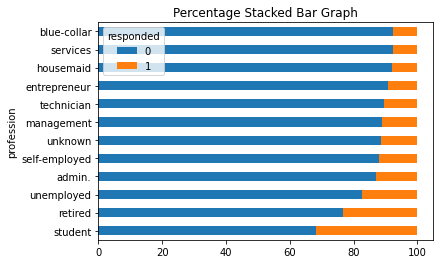

In [26]:
#plotting stacked-bar graph for profession feature
graph = cross_tab.drop(columns = 'All').transpose().astype('float')
graph.reset_index(inplace = True)
graph.drop(columns = 'All', inplace = True)
graph.plot( x = 'profession',  
            kind = 'barh',  
            stacked = True,  
            title = 'Percentage Stacked Bar Graph',  
            mark_right = True)

The above cross-table and Bar Graph shows: the profession which are likely to respond in decreasing order are students (31%) then retired (23%) then unemployed (17%). But in reality it is something different. To arrive to some conclusion, enough data points are must, approx. > 5% of the population (i.e. > 350), so that such behaviour can be considered statistically significant. Here student, retired, unemployed show good response but lack enough data points, hence their behaviour cannot be considered significant. 

With enough cases, Customer with profession Admin seems to respond better. 

This also shows the drawback of visualization provided by Percentage Stacked Bar graph, hence can be avoided.

### Marital

In [27]:
cross_tab = get_cross_table(data = data_train_1,
                           target_var = 'responded',
                           feature = 'marital')
#show cross-table
cross_tab

marital,unknown,single,married,divorced,All
responded,,,,,
0,75.00,86.14,89.65,90.49,88.73
1,25.00,13.86,10.35,9.51,11.27
All,8.00,1984.00,4232.00,778.00,7002.00


One may interpet that customer whose marital status is 'unkown', are more likely to respond but looking at the cross-table, it is observed that just 8 customers belong to 'unkown' category, i.e. not enough data points. 

The bucket having enough data points and maximum response is 'Single' then follows 'Married' and then 'divorced'.

### schooling

In [28]:
cross_tab = get_cross_table(data = data_train_1,
                           target_var = 'responded',
                           feature = 'schooling')
#show cross-table
cross_tab

schooling,university.degree,unknown,professional.course,high.school,basic.4y,basic.6y,basic.9y,All
responded,,,,,,,,
0,86.60,87.86,89.24,89.50,90.80,91.11,91.84,88.73
1,13.40,12.14,10.76,10.50,9.20,8.89,8.16,11.27
All,1470.00,2266.00,641.00,1143.00,489.00,270.00,723.00,7002.00


'unkown' shows highest response rate but again, this bucket contains < 5% cases to consider such behaviour significant. Buckets with response in decreasing order (with significant data points i.e. > 5% of population) are University.degree then professional.course then high.school. 

Higher the education level, higher is the response rate.  

### Default

In [29]:
cross_tab = get_cross_table(data = data_train_1,
                           target_var = 'responded',
                           feature = 'default')
#show cross-table
cross_tab

default,yes,no,unknown,All
responded,,,,
0,100.00,87.24,94.84,88.73
1,0.00,12.76,5.16,11.27
All,1.00,5626.00,1375.00,7002.00


Non defaulters have higher response rate then 'unkown' bucket. Trend in defaulters can't be estimated because of not enough cases.

### Housing

In [30]:
cross_tab = get_cross_table(data = data_train_1,
                           target_var = 'responded',
                           feature = 'housing')
#show cross-table
cross_tab

housing,unknown,yes,no,All
responded,,,,
0,84.71,88.30,89.42,88.73
1,15.29,11.70,10.58,11.27
All,157.00,3651.00,3194.00,7002.00


Customers having a housing loan are more likely to respond than no housing loan. Though 'unkown' has maximum response but samples are lower than 5% population

### Loan

In [31]:
cross_tab = get_cross_table(data = data_train_1,
                           target_var = 'responded',
                           feature = 'loan')
#show cross-table
cross_tab

loan,unknown,no,yes,All
responded,,,,
0,84.71,88.62,89.88,88.73
1,15.29,11.38,10.12,11.27
All,157.00,5758.00,1087.00,7002.00


Customers with no Personal loan tend to respond more than one with Personal loan. Though 'unkown' has maximum response but samples are lower than 5% population



### Contact

In [32]:
cross_tab = get_cross_table(data = data_train_1,
                           target_var = 'responded',
                           feature = 'contact')
#show cross-table
cross_tab

contact,cellular,telephone,All
responded,,,
0,85.22,94.81,88.73
1,14.78,5.19,11.27
All,4439.00,2563.00,7002.00


Customers who prefer Cellular mode of contact have more response rate than telephone mode.

### Month

In [33]:
cross_tab = get_cross_table(data = data_train_1,
                           target_var = 'responded',
                           feature = 'month')
#show cross-table
cross_tab

month,dec,sep,mar,oct,apr,jun,jul,aug,nov,may,All
responded,,,,,,,,,,,
0,48.15,48.54,48.91,58.96,77.38,90.32,90.86,90.89,92.06,92.84,88.73
1,51.85,51.46,51.09,41.04,22.62,9.68,9.14,9.11,7.94,7.16,11.27
All,27.00,103.00,92.00,134.00,473.00,888.00,1149.00,1054.00,680.00,2402.00,7002.00


Though it seems like December has the highest response but it has lower sample size (< 5%). In fact, months: mar, sep, oct follow dec in greater response but they too have < 5% cases i.e. not statistically significant behaviour. Hence, April has > 5% cases and higher response rate (23%) than rest.

### day_of_week

In [34]:
cross_tab = get_cross_table(data = data_train_1,
                           target_var = 'responded',
                           feature = 'day_of_week')
#show cross-table
cross_tab

day_of_week,tue,Never,fri,thu,wed,mon,All
responded,,,,,,,
0,87.86,88.16,88.19,88.41,89.04,90.30,88.73
1,12.14,11.84,11.81,11.59,10.96,9.70,11.27
All,1277.00,659.00,1152.00,1312.00,1241.00,1361.00,7002.00


Monday seem to have least response than rest of the days.

### poutcome

In [35]:
cross_tab = get_cross_table(data = data_train_1,
                           target_var = 'responded',
                           feature = 'poutcome')
#show cross-table
cross_tab

poutcome,success,failure,nonexistent,All
responded,,,,
0,32.34,87.89,91.04,88.73
1,67.66,12.11,8.96,11.27
All,235.00,760.00,6007.00,7002.00


Customer whose previous campaign ended up as a failure has higher response than the first time customers. Success has not enough cases, to consider such behaviour significant.

## Ordinal variables

### Customer Age

In [36]:
#Mean imputation

feature = 'custAge_meanImputed'
print("Bins threshold: " + str(thold_dict[feature]))
cross_tab = get_cross_table(data = data_train_1,
                           target_var = 'responded',
                           feature = feature,
                           variable_type = 'ordinal')
#show cross-table
cross_tab

Bins threshold: [-inf, 34.0, 39.91575368341519, 44.0, inf]


custAge_meanImputed,0.0,1.0,2.0,3.0,All
responded,,,,,
0,86.57,91.77,89.28,88.09,88.73
1,13.43,8.23,10.72,11.91,11.27
All,1735.00,1203.00,2276.00,1788.00,7002.00


Younder age and older age customers are highly likely to repsond to an isnsurance offer.

In [37]:
#Constant imputation


feature = 'custAge_constImputation'
print("Bins threshold: " + str(thold_dict[feature]))
cross_tab = get_cross_table(data = data_train_1,
                           target_var = 'responded',
                           feature = feature,
                           variable_type = 'ordinal')
#show cross-table
cross_tab

Bins threshold: [-inf, 22.0, 34.0, 44.0, inf]


custAge_constImputation,0.0,1.0,2.0,3.0,All
responded,,,,,
0,87.95,86.94,91.87,88.09,88.73
1,12.05,13.06,8.13,11.91,11.27
All,1735.00,1708.00,1771.00,1788.00,7002.00


Younder age and older age customers are highly likely to repsond to an isnsurance offer.

### Campaign

In [38]:
feature = 'campaign'
print("Bins threshold: " + str(thold_dict[feature]))
cross_tab = get_cross_table(data = data_train_1,
                           target_var = 'responded',
                           feature = feature,
                           variable_type = 'ordinal')
#show cross-table
cross_tab

Bins threshold: [-inf, 2.0, 3.0, inf]


campaign,0.0,1.0,2.0,All
responded,,,,
0,86.80,89.68,90.56,88.73
1,13.20,10.32,9.44,11.27
All,2970.00,1860.00,2172.00,7002.00


Higher ther number of campaign done for a customer, lower is the response rate

### Employment Variation Rate 

In [39]:
feature = 'emp.var.rate'
print("Bins threshold: " + str(thold_dict[feature]))
cross_tab = get_cross_table(data = data_train_1,
                           target_var = 'responded',
                           feature = feature,
                           variable_type = 'ordinal')
#show cross-table
cross_tab

Bins threshold: [-inf, -1.8, 1.1, inf]


emp.var.rate,0.0,1.0,2.0,All
responded,,,,
0,60.96,82.79,95.62,88.73
1,39.04,17.21,4.38,11.27
All,456.00,2527.00,4019.00,7002.00


Higher the employment variation rate, lower is the response.

### Consumer Price Index 

In [40]:
feature = 'cons.price.idx'
print("Bins threshold: " + str(thold_dict[feature]))
cross_tab = get_cross_table(data = data_train_1,
                           target_var = 'responded',
                           feature = feature,
                           variable_type = 'ordinal')
#show cross-table
cross_tab

Bins threshold: [-inf, 93.075, 93.444, 93.994, inf]


cons.price.idx,0.0,1.0,2.0,3.0,All
responded,,,,,
0,79.70,87.86,92.70,91.66,88.73
1,20.30,12.14,7.30,8.34,11.27
All,1547.00,1087.00,2041.00,2327.00,7002.00


Higher the consumer price index, lower is the response

### Consumer Confidence Index 

In [41]:
feature = 'cons.conf.idx'
print("threshold: " + str(thold_dict[feature]))
cross_tab = get_cross_table(data = data_train_1,
                           target_var = 'responded',
                           feature = feature,
                           variable_type = 'ordinal')
#show cross-table
cross_tab

threshold: [-inf, -42.7, -41.8, -36.4, inf]


cons.conf.idx,0.0,1.0,2.0,3.0,All
responded,,,,,
0,84.65,95.07,82.19,89.95,88.73
1,15.35,4.93,17.81,10.05,11.27
All,1596.00,1663.00,1106.00,2637.00,7002.00


No trend observed. Trend is bumpy

### Euribor 3 Month Rate 

In [42]:
feature = 'euribor3m'
print("threshold: " + str(thold_dict[feature]))
cross_tab = get_cross_table(data = data_train_1,
                           target_var = 'responded',
                           feature = feature,
                           variable_type = 'ordinal')
#show cross-table
cross_tab

threshold: [-inf, 1.334, 4.857, 4.961, inf]


euribor3m,0.0,1.0,2.0,3.0,All
responded,,,,,
0,72.89,90.28,95.36,95.08,88.73
1,27.11,9.72,4.64,4.92,11.27
All,1671.00,1635.00,1746.00,1950.00,7002.00


Higher the Euribor 3 Month rate, lower is the response from the customers.

### Number of employees 

In [43]:
feature = 'nr.employed'
print("threshold: " + str(thold_dict[feature]))
cross_tab = get_cross_table(data = data_train_1,
                           target_var = 'responded',
                           feature = feature,
                           variable_type = 'ordinal')
#show cross-table
cross_tab

threshold: [-inf, 5099.1, 5191.0, inf]


nr.employed,0.0,1.0,2.0,All
responded,,,,
0,56.63,85.51,95.54,88.73
1,43.37,14.49,4.46,11.27
All,830.00,1532.00,4640.00,7002.00


Higher the number of employees in a firm, lower is the response rate.

## fl_first_time_contact

In [44]:
feature = 'fl_first_time_contact'
cross_tab = get_cross_table(data = data_train_1,
                           target_var = 'responded',
                           feature = feature,
                           variable_type = 'ordinal')
#show cross-table
cross_tab

fl_first_time_contact,0,1,All
responded,,,
0,74.77,91.04,88.73
1,25.23,8.96,11.27
All,995.00,6007.00,7002.00


First timers have lower response rate than previous contacted customers.

# Univariate Feature Selection

## 1. Chi-squared test 

Chi-square test help in understanding the relation between given input feature and the target variable. i.e. is the observed distribution by chance? 
applicable to categorical features and target variable

In [45]:
pval_cols, pval_table, features_without_chi2 = chi2_test(data_train_1,
                                                         target_var = 'responded',
                                                         thold_for_pvalue = 0.05)

In [46]:
dropped_feature = []
for feature in data_train_1.drop(columns = ['id','responded']).columns:
    if feature not in pval_cols:
        dropped_feature.append(feature)

print("Features shortlisted by Chi2 test: \n" + str(pval_cols))
print("\nFeatures discared: "+ str(dropped_feature))

Features shortlisted by Chi2 test: 
['nr.employed', 'poutcome', 'emp.var.rate', 'euribor3m', 'month', 'fl_first_time_contact', 'cons.price.idx', 'contact', 'cons.conf.idx', 'profession', 'custAge_constImputation', 'campaign', 'custAge_meanImputed', 'schooling']

Features discared: ['marital', 'default', 'housing', 'loan', 'day_of_week']


In [47]:
#Discarding above features
data_train_2 = data_train_1[['id','responded'] + pval_cols]
data_train_2.to_pickle(path + "pickle_response_model/data_train_pre_dummy.p")
data_train_2.head()

,id,responded,nr.employed,poutcome,emp.var.rate,euribor3m,month,fl_first_time_contact,cons.price.idx,contact,cons.conf.idx,profession,custAge_constImputation,campaign,custAge_meanImputed,schooling
0,6691,0,2.0,nonexistent,2.0,2.0,may,1,3.0,telephone,3.0,entrepreneur,0.0,2.0,2.0,unknown
1,903,0,2.0,nonexistent,2.0,1.0,may,1,3.0,telephone,3.0,blue-collar,2.0,1.0,1.0,unknown
2,130,0,2.0,nonexistent,2.0,2.0,jun,1,3.0,telephone,2.0,admin.,3.0,1.0,3.0,university.degree
3,1476,0,2.0,nonexistent,1.0,3.0,oct,1,2.0,telephone,2.0,entrepreneur,2.0,0.0,1.0,university.degree
4,4002,0,2.0,failure,1.0,1.0,nov,0,1.0,cellular,1.0,admin.,3.0,0.0,3.0,high.school


## 2. Correlation

Correlation is a measure of how two variables change together.

### One hot encoding 

Before checking correlation, one hot encoding Nominal variables.

In [48]:
#One hot encoding Nominal variables
data_train_3 = pd.get_dummies(data_train_2, columns=["poutcome","month","contact","profession","schooling"])

In [49]:
'''performing Correlation test of ordinal variables with target variable'''

#spearman: as it non parmetric and captures montonic trend
correlation_with_tar_var = data_train_3.drop(columns = ['id','responded']).corrwith(data_train_1['responded'],
                                                                                    method='spearman')  

print("Correlation of ordinal variables with target variable: ")
correlation_with_tar_var.sort_values()

Correlation of ordinal variables with target variable: 


nr.employed                     -0.345139
emp.var.rate                    -0.280009
euribor3m                       -0.247296
fl_first_time_contact           -0.179654
poutcome_nonexistent            -0.179654
contact_telephone               -0.146081
cons.price.idx                  -0.131634
month_may                       -0.093868
profession_blue-collar          -0.059570
campaign                        -0.052213
profession_services             -0.036226
month_nov                       -0.034508
schooling_basic.9y              -0.033351
month_jul                       -0.029843
month_aug                       -0.028756
cons.conf.idx                   -0.025810
month_jun                       -0.019085
custAge_constImputation         -0.018307
schooling_basic.4y              -0.017901
profession_housemaid            -0.016737
schooling_basic.6y              -0.015069
profession_entrepreneur         -0.013872
profession_technician           -0.012084
schooling_high.school           -0

Dropping columns having very little correlation with target variable. Hence removing them below.

In [50]:
#dropping columns having very little correlation with target variable i.e. (> -0.05 and < 0.05)
cols_to_drop = list(correlation_with_tar_var[(correlation_with_tar_var > -0.05) & (correlation_with_tar_var < 0.05)].index)

print("dropping  " + str(len(cols_to_drop)) + " columns: "+str(cols_to_drop))

#removing 'custAge_meanImputed'
data_train_3.drop(columns = cols_to_drop, inplace = True)

#getting correlation with other variables
corr = data_train_3.drop(columns = ['id', 'responded']).corr()
corr.style.background_gradient(cmap = 'PuBu')

dropping  24 columns: ['cons.conf.idx', 'custAge_constImputation', 'custAge_meanImputed', 'poutcome_failure', 'month_aug', 'month_jul', 'month_jun', 'month_nov', 'profession_admin.', 'profession_entrepreneur', 'profession_housemaid', 'profession_management', 'profession_self-employed', 'profession_services', 'profession_technician', 'profession_unemployed', 'profession_unknown', 'schooling_basic.4y', 'schooling_basic.6y', 'schooling_basic.9y', 'schooling_high.school', 'schooling_professional.course', 'schooling_university.degree', 'schooling_unknown']


,nr.employed,emp.var.rate,euribor3m,fl_first_time_contact,cons.price.idx,campaign,poutcome_nonexistent,poutcome_success,month_apr,month_dec,month_mar,month_may,month_oct,month_sep,contact_cellular,contact_telephone,profession_blue-collar,profession_retired,profession_student
nr.employed,1.000000,0.843442,0.781780,0.468875,0.566907,0.104586,0.468875,-0.358486,-0.236416,-0.134624,-0.167572,-0.004320,-0.255788,-0.270883,-0.348351,0.348351,0.097300,-0.148468,-0.148306
emp.var.rate,0.843442,1.000000,0.830551,0.449986,0.795047,0.139921,0.449986,-0.256683,-0.222132,-0.148517,-0.095227,0.052076,-0.252216,-0.175874,-0.432656,0.432656,0.098598,-0.112559,-0.108977
euribor3m,0.781780,0.830551,1.000000,0.450479,0.600470,0.118174,0.450479,-0.244934,-0.151170,-0.084185,-0.105579,-0.330988,-0.155793,-0.169330,-0.185288,0.185288,0.026907,-0.076537,-0.109842
fl_first_time_contact,0.468875,0.449986,0.450479,1.000000,0.323275,0.069158,1.000000,-0.457882,-0.103956,-0.080274,-0.046434,-0.026426,-0.107353,-0.133741,-0.243023,0.243023,0.051615,-0.061067,-0.070844
cons.price.idx,0.566907,0.795047,0.600470,0.323275,1.000000,0.084127,0.323275,-0.077704,-0.157517,-0.094643,-0.128245,-0.030855,-0.083632,0.013803,-0.632246,0.632246,0.046936,-0.033921,-0.051219
campaign,0.104586,0.139921,0.118174,0.069158,0.084127,1.000000,0.069158,-0.034749,-0.046292,-0.007930,-0.018481,-0.001860,-0.067168,-0.046457,-0.070894,0.070894,0.013267,-0.002995,-0.030099
poutcome_nonexistent,0.468875,0.449986,0.450479,1.000000,0.323275,0.069158,1.000000,-0.457882,-0.103956,-0.080274,-0.046434,-0.026426,-0.107353,-0.133741,-0.243023,0.243023,0.051615,-0.061067,-0.070844
poutcome_success,-0.358486,-0.256683,-0.244934,-0.457882,-0.077704,-0.034749,-0.457882,1.000000,0.016194,0.090765,0.082957,-0.066174,0.118668,0.168249,0.108678,-0.108678,-0.059302,0.053916,0.066141
month_apr,-0.236416,-0.222132,-0.151170,-0.103956,-0.157517,-0.046292,-0.103956,0.016194,1.000000,-0.016746,-0.031057,-0.194498,-0.037596,-0.032888,0.159633,-0.159633,0.004422,0.025191,0.040888
month_dec,-0.134624,-0.148517,-0.084185,-0.080274,-0.094643,-0.007930,-0.080274,0.090765,-0.016746,1.000000,-0.007179,-0.044959,-0.008691,-0.007602,0.028142,-0.028142,-0.027639,0.033831,-0.008724


The above correaltion matrix show that, highly correlated features are:
    1. 'euribor3m' with 'emp.var.rate'
    2. 'emp.var.rate' with 'nr.employed'
    3. 'cons.price.idx' with 'emp.var.rate'

In [51]:
'''removing one of the features having threshold > 0.75'''
data_train_4 = correlation(data_train_3.drop(columns = ['id','responded']), threshold = 0.75)
data_train_4['id'] = data_train_3['id']
data_train_4['responded'] = data_train_3['responded']

#final heat map of correlation
corr = data_train_4.drop(columns = ['id', 'responded']).corr()
corr.style.background_gradient(cmap = 'PuBu')

,nr.employed,fl_first_time_contact,cons.price.idx,campaign,poutcome_success,month_apr,month_dec,month_mar,month_may,month_oct,month_sep,contact_cellular,profession_blue-collar,profession_retired,profession_student
nr.employed,1.000000,0.468875,0.566907,0.104586,-0.358486,-0.236416,-0.134624,-0.167572,-0.004320,-0.255788,-0.270883,-0.348351,0.097300,-0.148468,-0.148306
fl_first_time_contact,0.468875,1.000000,0.323275,0.069158,-0.457882,-0.103956,-0.080274,-0.046434,-0.026426,-0.107353,-0.133741,-0.243023,0.051615,-0.061067,-0.070844
cons.price.idx,0.566907,0.323275,1.000000,0.084127,-0.077704,-0.157517,-0.094643,-0.128245,-0.030855,-0.083632,0.013803,-0.632246,0.046936,-0.033921,-0.051219
campaign,0.104586,0.069158,0.084127,1.000000,-0.034749,-0.046292,-0.007930,-0.018481,-0.001860,-0.067168,-0.046457,-0.070894,0.013267,-0.002995,-0.030099
poutcome_success,-0.358486,-0.457882,-0.077704,-0.034749,1.000000,0.016194,0.090765,0.082957,-0.066174,0.118668,0.168249,0.108678,-0.059302,0.053916,0.066141
month_apr,-0.236416,-0.103956,-0.157517,-0.046292,0.016194,1.000000,-0.016746,-0.031057,-0.194498,-0.037596,-0.032888,0.159633,0.004422,0.025191,0.040888
month_dec,-0.134624,-0.080274,-0.094643,-0.007930,0.090765,-0.016746,1.000000,-0.007179,-0.044959,-0.008691,-0.007602,0.028142,-0.027639,0.033831,-0.008724
month_mar,-0.167572,-0.046434,-0.128245,-0.018481,0.082957,-0.031057,-0.007179,1.000000,-0.083380,-0.016117,-0.014099,0.061641,-0.034367,0.046051,0.029426
month_may,-0.004320,-0.026426,-0.030855,-0.001860,-0.066174,-0.194498,-0.044959,-0.083380,1.000000,-0.100936,-0.088294,-0.337720,0.124561,-0.060545,0.008071
month_oct,-0.255788,-0.107353,-0.083632,-0.067168,0.118668,-0.037596,-0.008691,-0.016117,-0.100936,1.000000,-0.017067,0.039057,-0.051916,0.113660,0.033479


In [52]:
print("Features left: {}".format(data_train_4.shape[1]-2))

Features left: 15


# Hypothesis Formation (Model Training)

## Building Model Pipeline

In [53]:
'''Build pipline of classifiers'''
# set all CPU
n_jobs = -1
random_state = 1000

# LogisticRegression
pipe_lr = Pipeline([('lr', LogisticRegression(random_state = random_state, n_jobs=n_jobs, max_iter = 500))])

# KNeighborsClassifier
pipe_knn = Pipeline([('knn', KNeighborsClassifier(n_jobs=n_jobs))])

# DecisionTreeClassifier
pipe_dt = Pipeline([('dt', DecisionTreeClassifier(random_state = random_state, max_features = 'auto'))])

# RandomForestClassifier
pipe_rf = Pipeline([('rf', RandomForestClassifier(random_state = random_state, oob_score = True, n_jobs = n_jobs))])

#Easy Ensemble
pipe_ee = Pipeline([('ee', EasyEnsembleClassifier(random_state = random_state, n_jobs = n_jobs))])


In [54]:
'''Set parameters for Grid Search '''

# set number of splits
n_splits = 5
cv = StratifiedKFold(shuffle=True, n_splits=n_splits, random_state=random_state)

# set for LogisticRegression
grid_params_lr = [{
                'lr__penalty': ['l1','l2', 'none'],
                'lr__C':  [0.01, 0.05, 0.1, 0.5, 1, 1.5, 10, 100],
                'lr__class_weight': ['balanced', None]  #Balanced can be useful in case of imabalanced classification
                }]

# set for KNeighborsClassifier
grid_params_knn = [{'knn__n_neighbors': np.arange(3,20,3)}]

# set for DecisionTreeClassifier
grid_params_dt = [{
                'dt__max_depth': np.arange(3,8,1),
                'dt__min_samples_leaf': [350, 370, 400, 500], #must be alteast 5% of total population.
                'dt__class_weight': ['balanced', None]  #Balanced can be useful in case of imabalanced classification
                }]

# set for RandomForestClassifier
grid_params_rf = [{
                'rf__min_samples_leaf': [350, 370, 400, 500], #must be alteast 5% of total population,
                'rf__max_depth': np.arange(3,8,1),
                'rf__n_estimators' : [25, 50, 75, 100, 250, 500],
                'rf__class_weight': ['balanced', None]  #Balanced can be useful in case of imabalanced classification
                }]

# set for Easy Ensemble
grid_params_ee = [{
                'ee__sampling_strategy': ['auto', 0.5, 0.33], 
                'ee__n_estimators' : [100, 150, 200, 300]
                }]

In [55]:
'''Grid search objects'''

"""
Using average_precision (PR-AUC) for Scoring because the response rate is just 11% (Imbalanced), hence we are insterested in 
knowing how well our model can identify response (class: 1)
"""

# for LogisticRegression
gs_lr = GridSearchCV(pipe_lr, param_grid = grid_params_lr,
                     scoring = 'average_precision', cv=cv) 

# for RandomForestClassifier
gs_rf = GridSearchCV(pipe_rf, param_grid = grid_params_rf,
                     scoring = 'average_precision', cv=cv)

# for KNeighborsClassifier
gs_knn = GridSearchCV(pipe_knn, param_grid = grid_params_knn,
                     scoring = 'average_precision', cv=cv)

# for DecisionTreeClassifier
gs_dt = GridSearchCV(pipe_dt, param_grid = grid_params_dt,
                     scoring = 'average_precision', cv=cv)

# for EasyEnsemble
gs_ee = GridSearchCV(pipe_ee, param_grid = grid_params_ee,
                     scoring = 'average_precision', cv=cv)

## Training and evaluating Model

Using average_precision (PR-AUC) for Scoring because the response rate is just 11% (Imbalanced), hence we are insterested in knowing how well our model can identify response (class: 1)

+++++++ Start New Model ++++++++++++++++++++++
Estimator is Logistic_reg
---------------------------------------------
best params {'lr__C': 100, 'lr__class_weight': None, 'lr__penalty': 'l2'}
best score (average_precision) is 0.4494
Best param CV test results (average_precision): mean: 0.4494 | std : 0.0401 | min : 0.4107 | max : 0.5049
---------------------------------------------
For complete train set:
average_precision is 0.4491 and ROC_AUC is 0.7925
It lasted for 12.965 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is Knn
---------------------------------------------
best params {'knn__n_neighbors': 18}
best score (average_precision) is 0.3816
Best param CV test results (average_precision): mean: 0.3816 | std : 0.0447 | min : 0.3152 

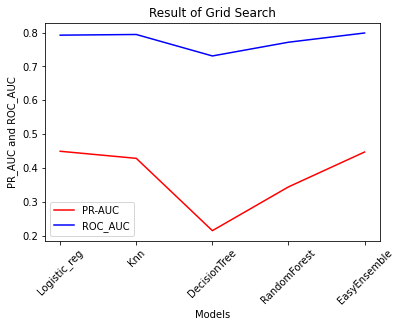

In [56]:
# models that we iterate over
look_for = [gs_lr, gs_knn, gs_dt, gs_rf, gs_ee]
# dict for later use 
model_dict = {0:'Logistic_reg', 1:'Knn', 2:'DecisionTree', 3:'RandomForest', 4: 'EasyEnsemble'}

#Function to iterate over models and obtain results
models, predictions_df, result_pr, result_roc = train_classification_model(data = data_train_4.drop(columns = ['id']),
                                                                           target_var = 'responded',
                                                                           look_for = look_for,
                                                                           model_dict = model_dict)

with open(path + "pickle_response_model/best_models.p", "wb") as f:
    pickle.dump(models, f)
    
predictions_df.to_pickle(path + "pickle_response_model/predictions_from_best_models.p")

plt.plot(model_dict.values(), result_pr.values(), c='r')
plt.plot(model_dict.values(), result_roc.values(), c='b')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.ylabel('PR_AUC and ROC_AUC')
plt.title('Result of Grid Search')
plt.legend(['PR-AUC', 'ROC_AUC'])
plt.show()

above plot is showing performance (PR-AUC and ROC-AUC) of the best model for each algorithms.

NOTE: Please refer the below conclusion for the insight from the above model training.

### Decile wise rank Ordering

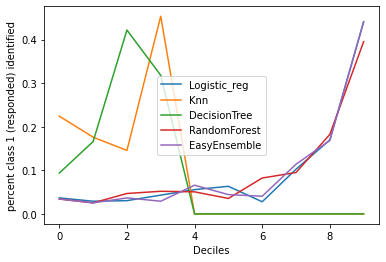

In [57]:
'''Functions helps in visualizing percentage of class 1 (responded) in each bucket of deciles'''
dict_class_1_dist = get_decile_wise_distribution(dataframe = predictions_df,
                                                 target_var = 'responded')

NOTE: Please refer the below conclusion for the insight from the above decile wise rank ordering

## Conclusion - for chossing the best model

We can finally choose one best model basis looking at below points:

1. Model Performance Score: 
Best average_precision (PR-AUC) has been obtained for Easy Ensemble and Logistic Regression. Logistic Regression has little delta between the average_precision value for complete train dataset vs mean test score of cross-validation compared to Easy Ensemble. Lesser the delta, lesser chances of overfitting. KNN has highest delta, indicating overfitting. In case of Random Forest and Decision Tree, this delta is small and std of test cv score is low for decision tree but overall performance is not outperforming Logistic Regression.

2. Decile wise Rank Ordering of Model output:
From the above graph, it can be concluded that desired montonic rank ordering is present for Easy Ensemble, Logistic Regression and Random Forest (some unevenness), which are perfectly good for scorecarding. Rest two have no rank ordering, hence not perfect for scoring. 

Logistic Rergession and Easy Ensemble satisfy both the above points.

Now, to select one of the models, we can go with Logistic Regression because it is simple (easy to understand) unlike Easy Ensemble which is complex. As standard deviation of Logistic is bit higher compared to Easy Ensemble, we can manage to lower it by following below steps. 

## Analysing and Improving Logistic Regression

In [58]:
'''Getting Model Co-efficients'''

#getting the trained log_reg model from 'models' list
log_reg = models[0].steps[0][1]  # 0th index is logistic regression

with open(path + "pickle_response_model/log_reg.p", "wb") as f:
    pickle.dump(log_reg, f)
    
#get co-efficients from model
model_coef = pd.DataFrame(data_train_4.drop(columns = ['id','responded']).columns, columns = ['features'])
model_coef['coef'] = log_reg.coef_[0]

#displaying the coefficients of the model in sorted order.
model_coef.sort_values(by = ['features','coef'])

,features,coef
3,campaign,-0.044548
2,cons.price.idx,0.092427
11,contact_cellular,0.489466
1,fl_first_time_contact,0.654848
5,month_apr,0.502016
6,month_dec,0.720556
7,month_mar,1.277672
8,month_may,-0.116908
9,month_oct,0.384870
10,month_sep,0.434434


Lookin at the above co-efficients, we can remove less important ones and try to optimize the model. 

We can remove eatures having lower co-efficients (i.e. > -0.1 and < 0.1)

In [59]:
''' Removing Features having lower co-efficients (i.e. > -0.1 and < 0.1) '''
columns_to_drop = model_coef[((model_coef.coef > -0.1) & (model_coef.coef < 0.1))].features    #less important features as per the model

data_train_5 = data_train_4.drop(columns = columns_to_drop)

print("Earlier, we had {} features for first iteration of Model Training,\nNow we have {} for second itertion of Logistic Regression Model training".format(data_train_4.shape[1]-2,data_train_5.shape[1]-2))

columns = list(data_train_5.drop(columns = ['id','responded']).columns)

with open(path + "pickle_response_model/final_features.p", "wb") as f:
    pickle.dump(columns, f)

Earlier, we had 15 features for first iteration of Model Training,
Now we have 12 for second itertion of Logistic Regression Model training


In [60]:
'''re-training logistic regression model'''

# models that we iterate over, this time iterating over logistic regression only.
look_for = [gs_lr]
# dict for later use 
model_dict = {0:'Logistic_reg'}


#Function to iterate over model and obtain results
models_1, predictions_df_1, result_pr_1, result_roc_1 = train_classification_model(data = data_train_5.drop(columns = ['id']),
                                                                                   target_var = 'responded',
                                                                                   look_for = look_for,
                                                                                   model_dict = model_dict)

with open(path + "pickle_response_model/best_models_1.p", "wb") as f:
    pickle.dump(models_1, f)
    
predictions_df_1.to_pickle(path + "pickle_response_model/predictions_from_best_models.p")

Using average_precision (PR-AUC) for Scoring because the response rate is just 11% (Imbalanced), hence we are insterested in knowing how well our model can identify response (class: 1)

+++++++ Start New Model ++++++++++++++++++++++
Estimator is Logistic_reg
---------------------------------------------
best params {'lr__C': 0.01, 'lr__class_weight': None, 'lr__penalty': 'none'}
best score (average_precision) is 0.4382
Best param CV test results (average_precision): mean: 0.4382 | std : 0.0351 | min : 0.4038 | max : 0.4895
---------------------------------------------
For complete train set:
average_precision is 0.4336 and ROC_AUC is 0.7961
It lasted for 6.811 sec
++++++++ End Model +++++++++++++++++++++++++++




It is observed that, there has been a decrease in delta between average precision of complete train set and mean cv test score, without dropping overall model performance. 
i.e. earlier: (0.449, 0.449)  ---> now: (0.438, 0.434) 

Note: first value in tuple indicates train score and second value in tuple indicates mean cv test score.

Most Importantly, standard deviation of average_precision CV test score has came down to 0.035 from 0.04.

This means, we have succefully optimized the model (lesser features, same performance, more stability) and have similar Std as EasyEnsmble. So no need to use complex model as EasyEsemble.

In [61]:
'''Getting Model Co-efficients of recent logistic regression'''

#getting the trained log_reg model from 'models' list
log_reg_final = models_1[0].steps[0][1]  # 0th index is logistic regression

#saving as pickle
with open(path + "pickle_response_model/log_reg_final.p", "wb") as f:
    pickle.dump(log_reg_final, f)
    
prediction_train = data_train_5[['id','responded']] 
prediction_train['probability_class_1'] = log_reg_final.predict_proba(data_train_5.drop(columns = ['id','responded']))[:,1]
    
#get co-efficients from model
model_coef_final = pd.DataFrame(data_train_5.drop(columns = ['id','responded']).columns, columns = ['features'])
model_coef_final['coef'] = log_reg_final.coef_[0]

#displaying the coefficients of the model in sorted order.
model_coef_final.sort_values(by = ['features','coef'])

,features,coef
9,contact_cellular,0.373928
1,fl_first_time_contact,0.633404
3,month_apr,0.484553
4,month_dec,0.624658
5,month_mar,1.210330
6,month_may,-0.199607
7,month_oct,0.384562
8,month_sep,0.518227
0,nr.employed,-1.080579
2,poutcome_success,2.118176


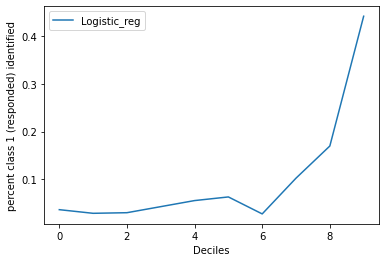

In [62]:
'''Functions helps in visualizing percentage of class 1 (responded) in each bucket of deciles'''
dict_class_1_dist = get_decile_wise_distribution(dataframe = predictions_df[['Logistic_reg','responded']],
                                                 target_var = 'responded')

## Deciding Optimal Cut-off

Getting Optimal cut-off for Model output, so that we can decide which customer belongs to which class. 

Here we will use F-score to decide cut-off, because we have dealt with PR-AUC for model performance as we were interested in identifying responsive customers out of all and F-score goes best with PR-AUC.

Considering, we want balance of Precision and Recall, we will use F1-score.

In [63]:
'''Predicting class using model output and getting confusion matrix'''

#function to get optimum cut-off using f1-score
optimum_cutoff = get_optimal_cutoff(prediction = prediction_train,
                                    target_var = 'responded')

print("Optimum cut-off using f1-score: {}".format(optimum_cutoff))

get_confusion_matrix(data_prediction = prediction_train,
                     model_output = 'probability_class_1',
                     target_var = 'responded',
                     cutoff = optimum_cutoff)

Optimum cut-off using f1-score: 0.22

Precision is 0.4604 and recall is 0.4943, at f1-score: 0.22

Confusion Matrix (percentage):
++++++++++++++++++++++++++++++
Note: Row is Actual and columns is Predicted
           0         1
0  82.205084  6.526707
1   5.698372  5.569837


# Testing

In [69]:
'''Loading test data'''
data_test = pd.read_pickle(path + "pickle_response_model/data_test.p")

#Numeric features in model
numeric_features = ['fl_first_time_contact', 'nr.employed']

#nominal features in model
nominal_features = ['contact', 'month', 'poutcome', 'profession']

#Feature Creation
data_test['fl_first_time_contact'] = np.where(data_test['previous'] > 0, 0, 1)

#keeping only relevant features
data_test = data_test[['id','responded'] + numeric_features + nominal_features]


'''Binning Numeric Variables'''

#loading bucket threshold
with open(path + 'pickle_response_model/thold_dict.p', 'rb') as f:
    dict_thold = pickle.load(f)

#Binning the variables using pickled threshold
data_test_binned = data_test.copy()
for feature in numeric_features:
    if feature != 'fl_first_time_contact':  #this feature was not binned
        thold = dict_thold[feature][1:-1]
        #print(feature + ": "+ str(thold))
        new_values = []
        for value in data_test[feature]:
            flag = 0
            for i in range(len(thold)):
                if(value < thold[i]):
                    new_values.append(i)
                    flag = 1
                    break
            if(flag == 0):
                new_values.append(len(thold))
        data_test_binned[feature] = new_values
    

In [70]:
'''
Below snippet is useful when a feature in a test set has an additional category which was never faced in train set, 
hence removing it after one_hot_encoding. To make sure whatever category where there in train are present in test,
we append test_ohe to structure of train_ohe dataframe and impute missing value with zero.
'''

#getting final one hot encoded features from model
with open(path + "pickle_response_model/final_features.p", "rb") as f:
    final_model_features = pickle.load(f)
    
final_model_features.append('id')
final_model_features.append('responded') 

#creating an empty dataframe which will have one hot encoded data, of similar structure from training time.
data_test_ohe = pd.DataFrame(columns = final_model_features)

#one hot encoding nominal features of testing data.
data_test_ohe_temp = pd.get_dummies(data_test_binned, columns = nominal_features)

#identifying and removing columns which are created for unseen category during training time. 
unnecessary_col = []
for feature in data_test_ohe_temp.columns:
    if feature not in final_model_features:
        unnecessary_col.append(feature)
        
data_test_ohe_temp.drop(columns = unnecessary_col, inplace = True)

#appending test one hot encoded data to above empty dataframe having training data structure.
data_test_ohe = data_test_ohe.append(data_test_ohe_temp)

#if some category was present in train data but not in test, then Null would appear after above step
#hence replacing null with zero
data_test_ohe.fillna(value = 0, inplace = True)

In [73]:
'''getting Model output and performance for Test set'''

with open(path + "pickle_response_model/log_reg_final.p", "rb") as f:
    log_reg_final = pickle.load(f)

#getting prediction
prediction_test = data_test_ohe[['id','responded']]    
prediction_test['probability_class_1'] = log_reg_final.predict_proba(data_test_ohe.drop(columns = ['id','responded']))[:,1]

#getting performance
roc_auc = round(roc_auc_score(prediction_test['responded'], prediction_test['probability_class_1']), 4)
average_precision = round(average_precision_score(prediction_test['responded'], prediction_test['probability_class_1']), 4)

print('Test set:')
print('++++++++++++++++++++++++++++++++++')
print('average_precision: {} \nROC_AUC: {}'.format(average_precision, roc_auc))

#confusion matrix
get_confusion_matrix(data_prediction = prediction_test,
                     model_output = 'probability_class_1',
                     target_var = 'responded',
                     cutoff = 0.22)

#saving prediction dataframe for PSI comparison during tagging batches:
prediction_test.to_pickle(path + "pickle_response_model/prediction_test.p")

Test set:
++++++++++++++++++++++++++++++++++
average_precision: 0.4448 
ROC_AUC: 0.7904

Precision is 0.4675 and recall is 0.518, at f1-score: 0.22

Confusion Matrix (percentage):
++++++++++++++++++++++++++++++
Note: Row is Actual and columns is Predicted
           0         1
0  82.119741  6.634304
1   5.420712  5.825243


For trainig set, logistic Regression had average_precision for Complete train set as 0.43 and mean CV test score as 0.43.
For test set, average_precison is 0.44. Confusion matrix is also similar to train set. Hence this model is holding true for Test set (unseen data) as well. 